<a href="https://colab.research.google.com/github/nhutd107/AI_CDT_20146509_-D.Nhu-/blob/main/CuoiKi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import thu vien

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [2]:
#tai du lieu tu dataset
BASE_DIR ='/content/drive/MyDrive/UTKFace'

In [3]:
## tao cac label - age, gender, ethnicity . doc du lieu tu BASE_DIR va tao ra
#3 danh sach cac gia tri

image_paths = []   #chua duong dan tuyet doi all tep 
age_labels = []    #chua nhan tuoi cua moi anh
gender_labels = []  #chua nhan doi tinh cua moi anh


for filename in tqdm(os.listdir(BASE_DIR)):   #ham tqdm: hien thi thanh tien trinh trong qua trinh doc du lieu
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')  
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/14823 [00:00<?, ?it/s]

In [4]:
# convert to dataframe (chuyen doi danh sach duong dan thanh mot dataFrame)

df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()  #hien thi 5 gia tri dau

,image,age,gender
0,/content/drive/MyDrive/UTKFace/37_0_0_20170117...,37,0
1,/content/drive/MyDrive/UTKFace/38_0_3_20170119...,38,0
2,/content/drive/MyDrive/UTKFace/36_0_3_20170119...,36,0
3,/content/drive/MyDrive/UTKFace/38_0_1_20170113...,38,0
4,/content/drive/MyDrive/UTKFace/35_0_2_20170116...,35,0


In [5]:
# map labels for gender
#tao ra mot tu dien với hai khóa - giá trị, tương ứng với nhãn giới tính và giới tính tương ứng.
gender_dict = {0:'Male', 1:'Female'}  #gan cac gia tri tuong ưng 1 0

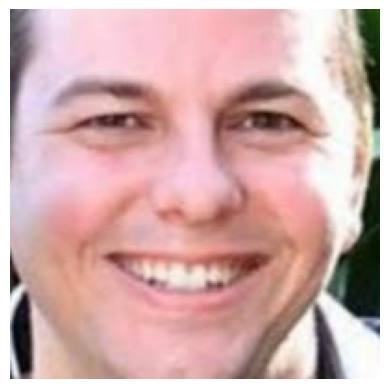

In [6]:
#phan tich du lieu tham do
from PIL import Image
img = Image.open(df['image'][0]) #mo va hien thi mot anh khuon mat dau tien trong dataframe
plt.axis('off')
plt.imshow(img);


<Axes: xlabel='age', ylabel='Density'>

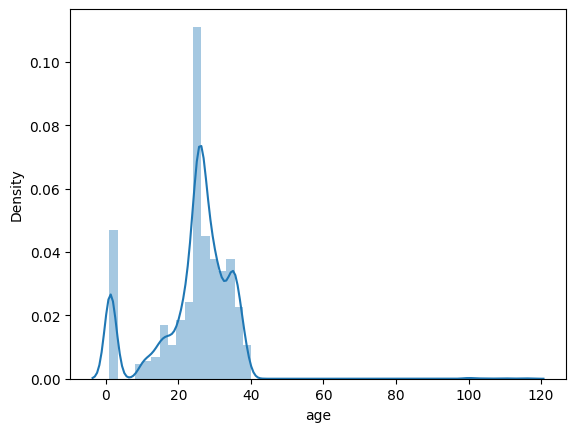

In [7]:
#ve bieu do phan bo do tuoi trong dataframe dung thu vien seaborn 
sns.distplot(df['age'])   #phan bo mat do xac xuat, bieu do histogram va mot duong con mat do xac xuat di kem

<Axes: ylabel='count'>

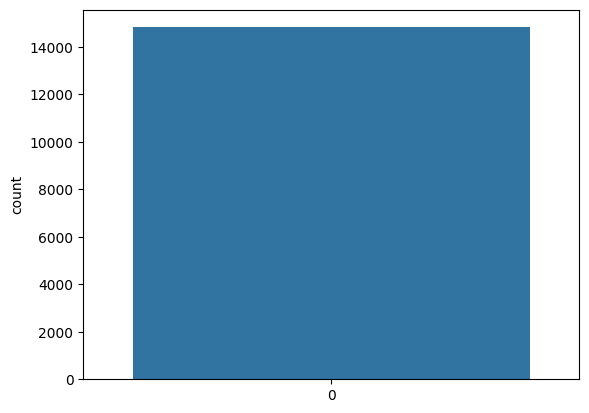

In [8]:
#ve bieu do dem so luong mau cho tung nhan gioi tinh trong datafram
sns.countplot(df['gender'])

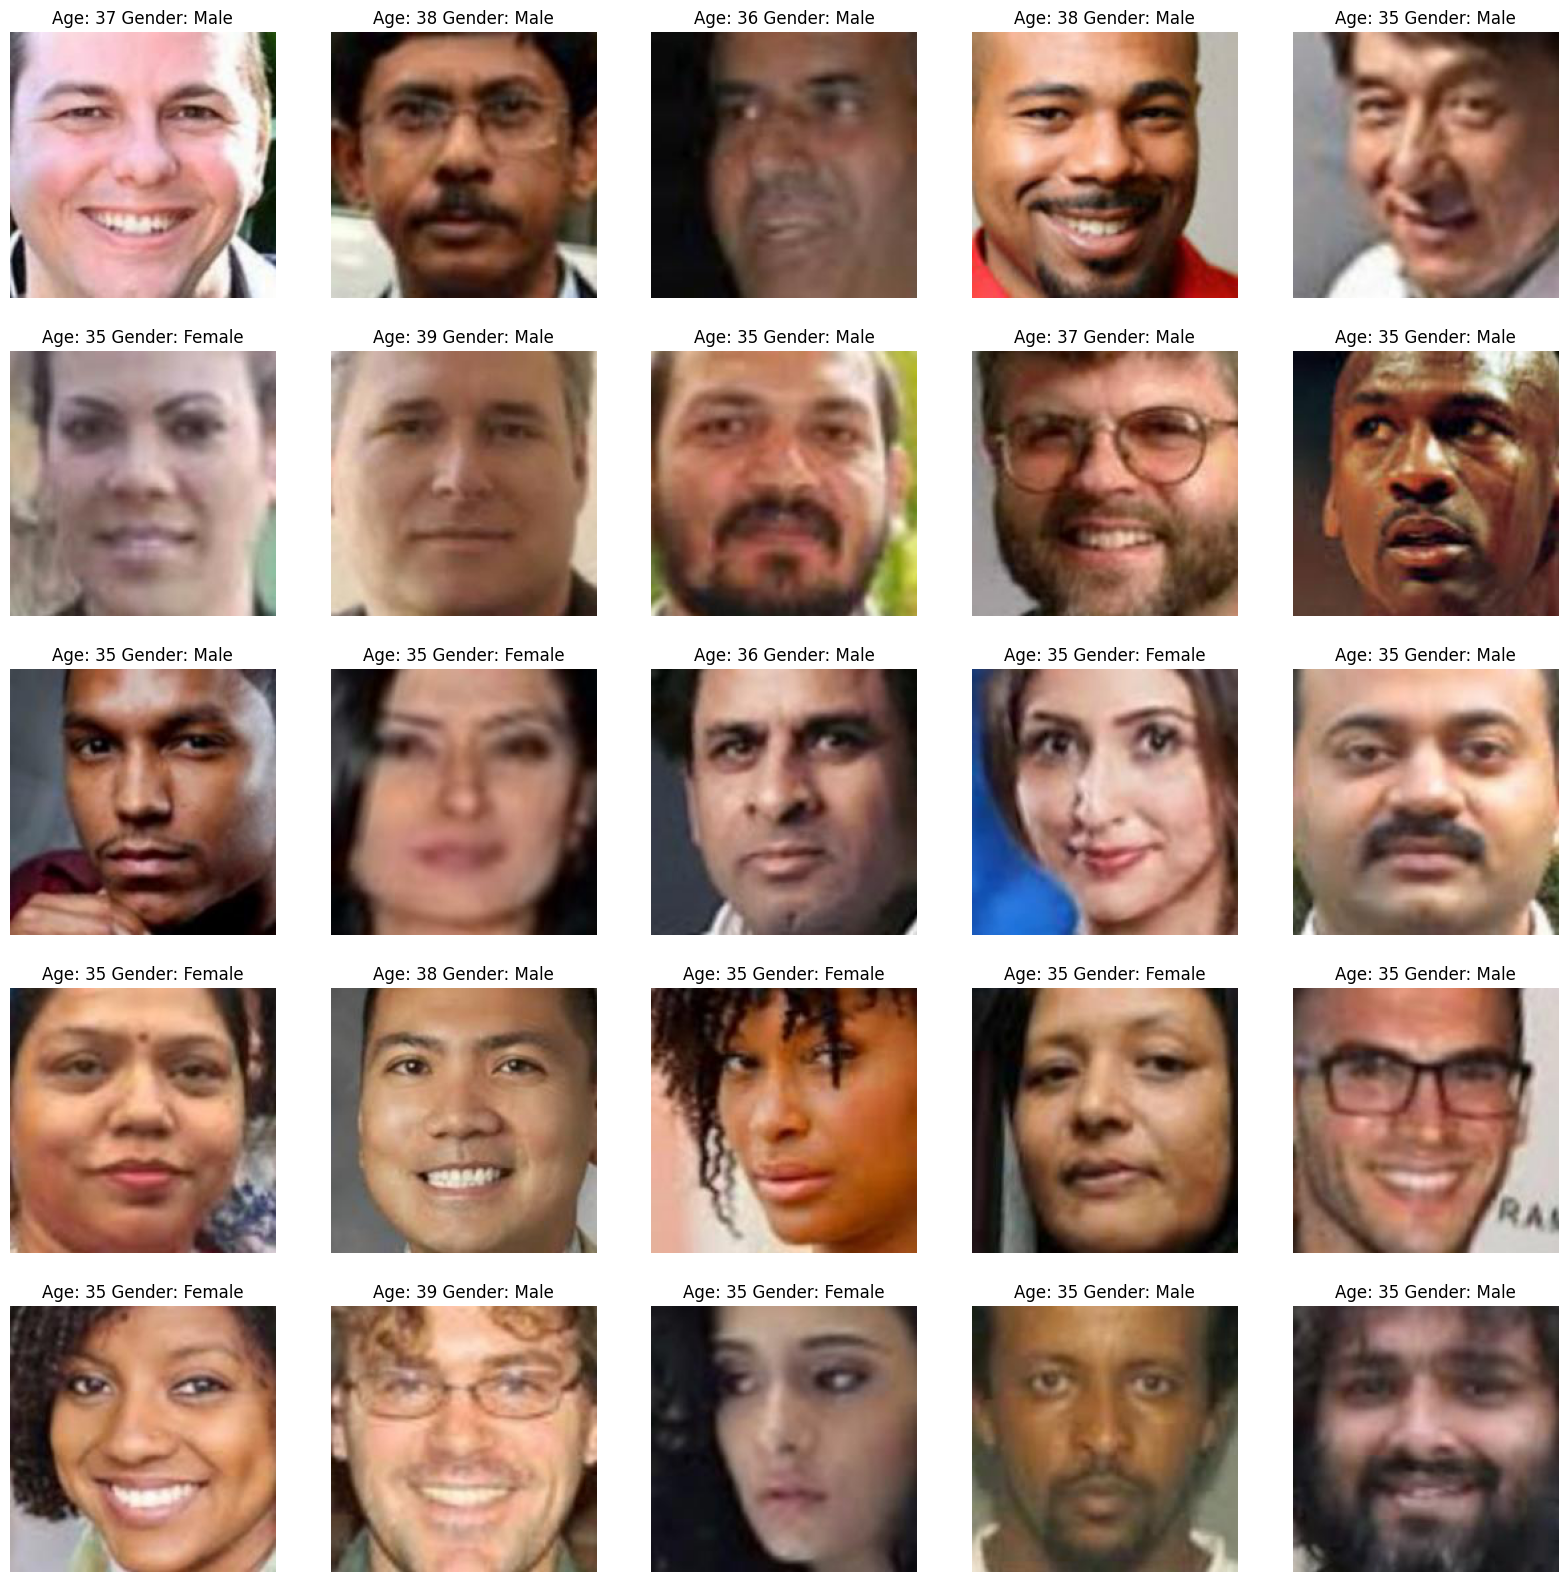

In [9]:
# to display grid of images
plt.figure(figsize=(20, 20))   #tao mot doi tuong kich thuoc 20x20
files = df.iloc[0:25]          #khong gian hien thi luoi anh 25 khuon mat

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')   #an cac truc cua do thi

In [10]:
#khai thac cac tinh nang
#cu the ham de truy xuat cac dac trung tren khuon mat
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)           #chuyen sang anh xam
        img = img.resize((128, 128), Image.ANTIALIAS)   #thay doi kich thuoc anh 128x128
        img = np.array(img)                             #chyen sang nupy de de dang thao tac
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1) 
    #kích thước (n_samples, height, width) sang kích thước (n_samples, height, width, channels),
    return features

In [11]:
#truy suat cac dac trung va tinh size
X = extract_features(df['image'])
X.shape

  0%|          | 0/14823 [00:00<?, ?it/s]

(14823, 128, 128, 1)

In [12]:
# normalize the images
#chuan hoa gia tri từ 255 để về [0,1] giup viec huan luyen ez hon
X = X/255.0

In [13]:
#tach rieng cac nhan de huan luyen ez hon
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
input_shape = (128, 128, 1)  #cao ,rong ,kenh

In [14]:
#tao mau (model)

inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])


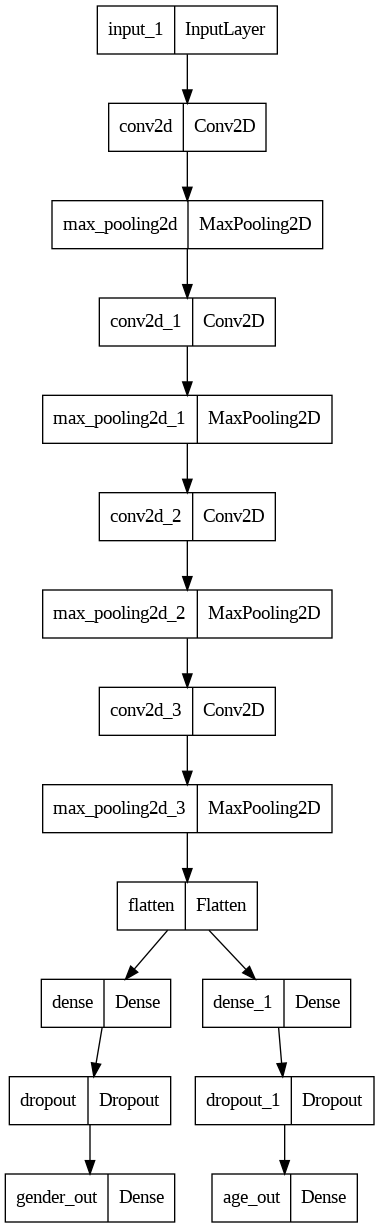

In [15]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [16]:
# train model
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
371/371 [==============================] - 22s 25ms/step - loss: 6.7601 - gender_out_loss: 0.6953 - age_out_loss: 6.0648 - gender_out_accuracy: 0.5353 - age_out_accuracy: 0.0000e+00 - val_loss: 16.5394 - val_gender_out_loss: 0.6960 - val_age_out_loss: 15.8434 - val_gender_out_accuracy: 0.4863 - val_age_out_accuracy: 0.3788
Epoch 2/30
371/371 [==============================] - 7s 20ms/step - loss: 5.8384 - gender_out_loss: 0.6912 - age_out_loss: 5.1472 - gender_out_accuracy: 0.5378 - age_out_accuracy: 0.0000e+00 - val_loss: 20.6172 - val_gender_out_loss: 0.6960 - val_age_out_loss: 19.9212 - val_gender_out_accuracy: 0.4863 - val_age_out_accuracy: 0.3788
Epoch 3/30
371/371 [==============================] - 8s 21ms/step - loss: 5.7728 - gender_out_loss: 0.6906 - age_out_loss: 5.0821 - gender_out_accuracy: 0.5386 - age_out_accuracy: 0.0000e+00 - val_loss: 17.4211 - val_gender_out_loss: 0.7044 - val_age_out_loss: 16.7166 - val_gender_out_accuracy: 0.4863 - val_age_out_accuracy: 0

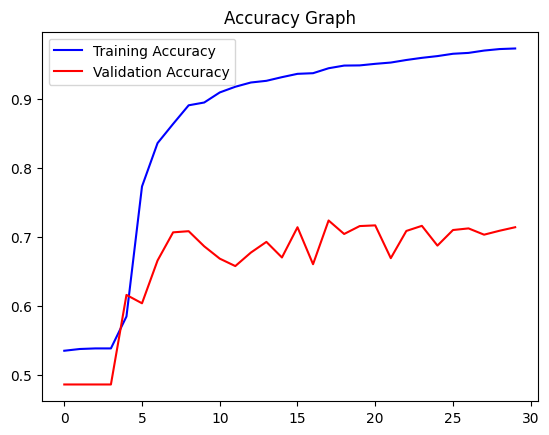

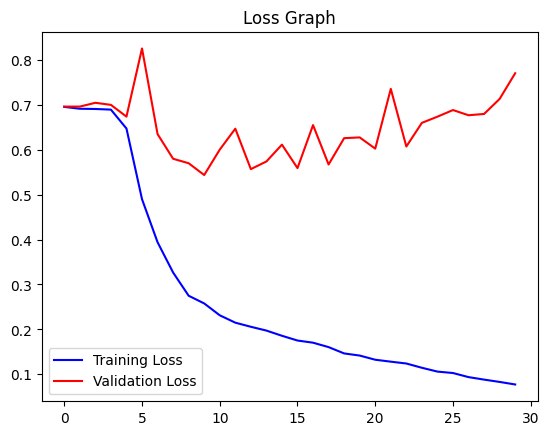

In [17]:
#ve ket qua

# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

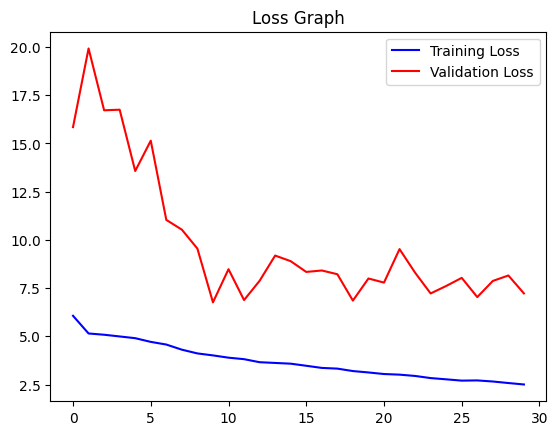

In [18]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


Original Gender: Female Original Age: 36
1/1 [==============================] - 0s 36ms/step
Predicted Gender: Female Predicted Age: 34


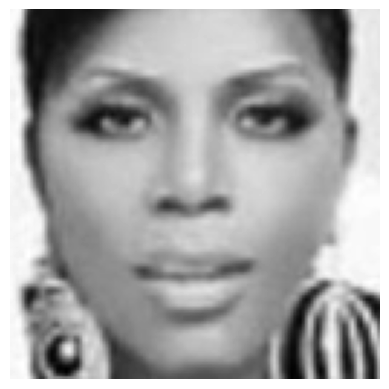

In [22]:
# Prediction with Test Data
image_index =101
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 30
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: 31


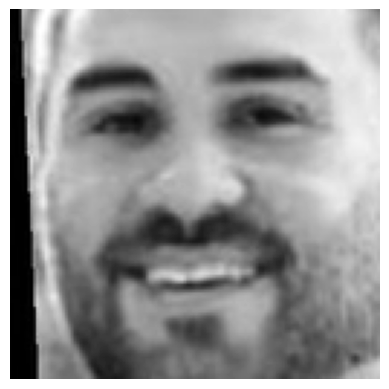

In [23]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 22
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Male Predicted Age: 21


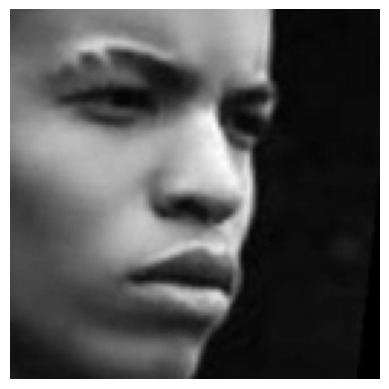

In [25]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 23
1/1 [==============================] - 0s 33ms/step
Predicted Gender: Female Predicted Age: 26


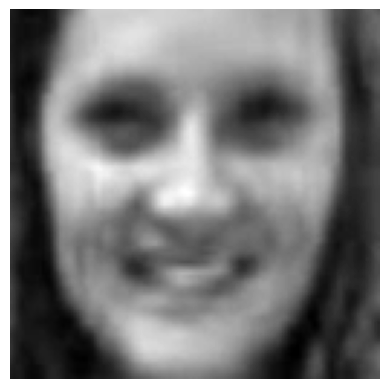

In [26]:
image_index = 10011
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');